In [29]:
'Test_Task2_With or without baby Detection using RanFor model and SVM model'

'Test_Task2_With or without baby Detection using RanFor model and SVM model'

In [30]:
import gc
gc.collect()

1500

In [31]:
%reset -f

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

# Test Measurements

In [33]:
import os
import numpy as np
import pandas as pd

# Define path (2 levels up -> Data/Processed)
file_path = os.path.join("..", "..", "Data", "Processed", "CarrierSeat_withoutBaby_Lowpassfilered_Label_0.npy")

# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Convert to DataFrame
dataframe_testdata = pd.DataFrame(
    loaded_array,
    columns=['Frequency', 'FFT Magnitude', 'Phase', 'Infant_Presence']
)

# Take first 2000 rows (or use sampling instead if needed)
dataframe_testdata = dataframe_testdata.iloc[:2000]
# dataframe_testdata = dataframe_testdata.sample(n=2000, random_state=42)

print(f"Data loaded from: {os.path.abspath(file_path)}")
dataframe_testdata

Data loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Data/Processed/CarrierSeat_withoutBaby_Lowpassfilered_Label_0.npy


,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.000,104749.366658,0.000000,1.0
1,78.125,52421.282760,-3.130457,1.0
2,156.250,2858.080997,1.630063,1.0
3,234.375,2785.146203,-0.997409,1.0
4,312.500,1836.985949,2.804369,1.0
...,...,...,...,...
1995,155859.375,1593.463658,2.052034,1.0
1996,155937.500,867.149039,-1.614056,1.0
1997,156015.625,447.175561,-0.331831,1.0
1998,156093.750,462.384006,2.885224,1.0


In [34]:
num_rows_test = len(dataframe_testdata)
num_rows_test

2000

In [35]:
fft_magnitudes_test = dataframe_testdata["FFT Magnitude"].values  # Convert to NumPy array
fft_magnitudes_test

array([104749.36665761,  52421.28276004,   2858.08099686, ...,
          447.17556066,    462.38400634,    681.57457988], shape=(2000,))

In [36]:
fft_frequencies_test = dataframe_testdata["Frequency"].values  # Convert to NumPy array
fft_frequencies_test

array([0.00000000e+00, 7.81250000e+01, 1.56250000e+02, ...,
       1.56015625e+05, 1.56093750e+05, 1.56171875e+05], shape=(2000,))

In [37]:
fft_phase_test = dataframe_testdata["Phase"].values  # Convert to NumPy array
fft_phase_test

array([ 0.        , -3.13045712,  1.6300633 , ..., -0.33183129,
        2.88522358,  0.70598984], shape=(2000,))

In [38]:
import numpy as np
from scipy.stats import entropy
from scipy.signal import find_peaks

def extract_features(fft_freqs, fft_mags, fft_phase):
    # Normalize magnitudes to prevent division errors
    norm_mags = fft_mags / np.sum(fft_mags) if np.sum(fft_mags) > 0 else fft_mags
    
    # Spectral Centroid (Weighted Mean of Frequencies)
    spectral_centroid = np.sum(fft_freqs * norm_mags) / np.sum(norm_mags)

    # Spectral Bandwidth (Spread around centroid)
    spectral_bandwidth = np.sqrt(np.sum(norm_mags * (fft_freqs - spectral_centroid) ** 2))

    # Spectral Flatness (Geometric Mean / Arithmetic Mean)
    spectral_flatness = np.exp(np.mean(np.log(fft_mags + 1e-10))) / np.mean(fft_mags + 1e-10)

    # Find peaks in the magnitude spectrum
    peaks, _ = find_peaks(fft_mags, height=0.1 * np.max(fft_mags))  # Adaptive threshold

    # Harmonic Ratio (Ratio of 2nd peak to 1st peak)
    if len(peaks) >= 2:
        harmonic_ratio = fft_mags[peaks[1]] / fft_mags[peaks[0]]
    else:
        harmonic_ratio = 0  # No second peak detected

    # Phase Features
    phase_variance = np.var(fft_phase)  # Variance of phase angles
    phase_mean = np.mean(fft_phase)  # Mean of phase angles
    phase_diff = np.mean(np.diff(fft_phase))  # Average phase difference between frequencies

    return {
        "mean_fft": np.mean(fft_mags),
        "std_fft": np.std(fft_mags),
        "max_fft": np.max(fft_mags),
        "min_fft": np.min(fft_mags),
        "median_fft": np.median(fft_mags),
        "sum_fft": np.sum(fft_mags),
        "spectral_entropy": entropy(norm_mags),  # Energy spread
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "spectral_flatness": spectral_flatness,
        "phase_variance": phase_variance,
        "phase_mean": phase_mean,
        "phase_diff": phase_diff,
    }

In [39]:
# Function to apply perturbation based on reference values
def add_perturbation(reference_features, num_rows, perturb_range=0.03):
    perturbed_data = []
    
    for _ in range(num_rows):
        perturbed_features = {
            key: value * (1 + np.random.uniform(-perturb_range, perturb_range)) 
            for key, value in reference_features.items()
        }
        perturbed_data.append(perturbed_features)
    
    return pd.DataFrame(perturbed_data)

In [40]:
# Extract features for fft_test
reference_features_test = extract_features(fft_frequencies_test, fft_magnitudes_test, fft_phase_test)
reference_features_test

{'mean_fft': np.float64(915.8702142992524),
 'std_fft': np.float64(2641.704753743293),
 'max_fft': np.float64(104749.36665761432),
 'min_fft': np.float64(0.9930308466425066),
 'median_fft': np.float64(741.4678771625448),
 'sum_fft': np.float64(1831740.428598505),
 'spectral_entropy': np.float64(7.136809174691093),
 'spectral_centroid': np.float64(64725.741214643764),
 'spectral_bandwidth': np.float64(45545.63935165247),
 'spectral_flatness': np.float64(0.7492610472047804),
 'phase_variance': np.float64(3.3049371648473924),
 'phase_mean': np.float64(-0.008210787923691202),
 'phase_diff': np.float64(0.00035317150426811804)}

In [41]:
# Generate a DataFrame with perturbed values for all rows in fft_test
num_rows_test = len(dataframe_testdata)
perturbed_test_df = add_perturbation(reference_features_test, num_rows_test, perturb_range=0.03)
perturbed_test_df

,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,spectral_flatness,phase_variance,phase_mean,phase_diff
0,910.345045,2642.016673,104898.532460,0.973726,736.749300,1.861828e+06,7.042343,63669.312896,44772.717797,0.730023,3.281710,-0.008223,0.000356
1,934.035043,2719.104264,103414.948216,1.007014,761.210169,1.799219e+06,7.070456,63180.399348,44460.401452,0.762654,3.344204,-0.008047,0.000363
2,934.077798,2683.218474,107534.617949,1.008268,757.717556,1.843989e+06,7.215839,64275.087346,46562.510454,0.733719,3.356740,-0.008130,0.000359
3,890.632236,2647.307464,106681.687948,1.015893,753.970395,1.833648e+06,6.939924,66274.318718,46307.742133,0.752700,3.347809,-0.008281,0.000357
4,897.631043,2625.399804,105671.312215,1.015482,728.167826,1.847358e+06,7.015648,66045.216576,46673.962787,0.738256,3.324991,-0.008163,0.000349
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,930.902778,2659.968731,104629.064021,0.965000,743.145905,1.884686e+06,7.161732,64814.562311,46271.079201,0.751671,3.263275,-0.008271,0.000361
1996,914.887553,2703.614429,102178.846642,0.982580,738.169692,1.862440e+06,7.067058,64853.058393,46198.525571,0.741714,3.379757,-0.007992,0.000358
1997,936.292907,2630.899680,106176.334926,0.994449,754.175019,1.819637e+06,7.116428,64568.365566,44969.245273,0.729707,3.290965,-0.008171,0.000348
1998,932.924198,2605.199508,105891.940844,0.997811,722.856067,1.829993e+06,6.984144,65583.924207,44234.370351,0.760263,3.310954,-0.008368,0.000361


In [42]:
dataframe_testdata

,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.000,104749.366658,0.000000,1.0
1,78.125,52421.282760,-3.130457,1.0
2,156.250,2858.080997,1.630063,1.0
3,234.375,2785.146203,-0.997409,1.0
4,312.500,1836.985949,2.804369,1.0
...,...,...,...,...
1995,155859.375,1593.463658,2.052034,1.0
1996,155937.500,867.149039,-1.614056,1.0
1997,156015.625,447.175561,-0.331831,1.0
1998,156093.750,462.384006,2.885224,1.0


In [43]:
len(perturbed_test_df),len(dataframe_testdata)

(2000, 2000)

In [44]:
# Ensure both DataFrames have the same number of rows
if len(dataframe_testdata) != len(perturbed_test_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_testdata_withfeatures = pd.concat([dataframe_testdata, perturbed_test_df], axis=1)

# Display the first few rows of the updated dataframe_testdata to verify
dataframe_testdata_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Infant_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,spectral_flatness,phase_variance,phase_mean,phase_diff
0,0.000,104749.366658,0.000000,1.0,910.345045,2642.016673,104898.532460,0.973726,736.749300,1.861828e+06,7.042343,63669.312896,44772.717797,0.730023,3.281710,-0.008223,0.000356
1,78.125,52421.282760,-3.130457,1.0,934.035043,2719.104264,103414.948216,1.007014,761.210169,1.799219e+06,7.070456,63180.399348,44460.401452,0.762654,3.344204,-0.008047,0.000363
2,156.250,2858.080997,1.630063,1.0,934.077798,2683.218474,107534.617949,1.008268,757.717556,1.843989e+06,7.215839,64275.087346,46562.510454,0.733719,3.356740,-0.008130,0.000359
3,234.375,2785.146203,-0.997409,1.0,890.632236,2647.307464,106681.687948,1.015893,753.970395,1.833648e+06,6.939924,66274.318718,46307.742133,0.752700,3.347809,-0.008281,0.000357
4,312.500,1836.985949,2.804369,1.0,897.631043,2625.399804,105671.312215,1.015482,728.167826,1.847358e+06,7.015648,66045.216576,46673.962787,0.738256,3.324991,-0.008163,0.000349


In [45]:
len(dataframe_testdata)

2000

In [46]:
import os
import numpy as np
import pandas as pd

# Define path (2 levels up -> Data/Processed)
file_path = os.path.join("..", "..", "Data", "Processed", "Withbaby_npy_array_Lowpassfiltered.npy")


# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Convert to DataFrame
dataframe_withbaby = pd.DataFrame(
    loaded_array,
    columns=['Frequency', 'FFT Magnitude', 'Phase', 'Infant_Presence']
)

print(f"Data loaded from: {os.path.abspath(file_path)}")
dataframe_withbaby


Data loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Data/Processed/Withbaby_npy_array_Lowpassfiltered.npy


,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.000000,85482.192762,2.659895e-18,1.0
1,92.917460,40258.220857,-3.125651e+00,1.0
2,185.834919,5221.175683,2.865319e+00,1.0
3,278.752379,3160.342162,-3.600372e-01,1.0
4,371.669838,110.182115,-4.779431e-01,1.0
...,...,...,...,...
21015,-464.587298,862.049715,2.715918e+00,1.0
21016,-371.669838,110.182115,4.779431e-01,1.0
21017,-278.752379,3160.342162,3.600372e-01,1.0
21018,-185.834919,5221.175683,-2.865319e+00,1.0


In [47]:
#dropping features

In [48]:
to_drop = {'spectral_centroid', 'sum_fft', 'max_fft', 'min_fft', 'phase_diff', 'mean_fft', 'phase_mean', 'std_fft'}
test_X = dataframe_testdata_withfeatures.drop(columns=['Infant_Presence'])  # Features
test_y = dataframe_testdata_withfeatures['Infant_Presence']  # Labels
test_x_dataset_1_reduced = test_X.drop(columns=to_drop)

In [49]:
test_x_dataset_1_reduced

,Frequency,FFT Magnitude,Phase,median_fft,spectral_entropy,spectral_bandwidth,spectral_flatness,phase_variance
0,0.000,104749.366658,0.000000,736.749300,7.042343,44772.717797,0.730023,3.281710
1,78.125,52421.282760,-3.130457,761.210169,7.070456,44460.401452,0.762654,3.344204
2,156.250,2858.080997,1.630063,757.717556,7.215839,46562.510454,0.733719,3.356740
3,234.375,2785.146203,-0.997409,753.970395,6.939924,46307.742133,0.752700,3.347809
4,312.500,1836.985949,2.804369,728.167826,7.015648,46673.962787,0.738256,3.324991
...,...,...,...,...,...,...,...,...
1995,155859.375,1593.463658,2.052034,743.145905,7.161732,46271.079201,0.751671,3.263275
1996,155937.500,867.149039,-1.614056,738.169692,7.067058,46198.525571,0.741714,3.379757
1997,156015.625,447.175561,-0.331831,754.175019,7.116428,44969.245273,0.729707,3.290965
1998,156093.750,462.384006,2.885224,722.856067,6.984144,44234.370351,0.760263,3.310954


In [50]:
test_y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1995    1.0
1996    1.0
1997    1.0
1998    1.0
1999    1.0
Name: Infant_Presence, Length: 2000, dtype: float64

# Testing the Random Forest Model

In [51]:
# import joblib

# Load the trained Random Forest model
# clf = joblib.load('random_forest_model_Baby_Detection.pkl')

# Example: Transform new data and make predictions
# y_pred = clf.predict(test_x_dataset_1_reduced)
#y_pred



import os
import joblib

# Define directory (2 levels up -> Models/RandomForest)
model_dir = os.path.join("..", "..", "Models", "Baby Detection and Seat Classification Random Forest")

# Define model path
model_path = os.path.join(model_dir, "random_forest_model_Baby_Detection.pkl")

# Load the trained Random Forest model
clf = joblib.load(model_path)

print(f"Model loaded from: {os.path.abspath(model_path)}")

# Align test data columns with what the model expects
if hasattr(clf, "feature_names_in_"):
    test_x_dataset_1_reduced = test_x_dataset_1_reduced[clf.feature_names_in_]

# Predict
y_pred = clf.predict(test_x_dataset_1_reduced)
y_pred

Model loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Baby Detection and Seat Classification Random Forest/random_forest_model_Baby_Detection.pkl


array([1., 1., 1., ..., 1., 1., 1.], shape=(2000,))

In [52]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional: More detailed report
print("\nClassification Report:")
print(classification_report(test_y, y_pred))

# Optional: Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))


Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Confusion Matrix:
[[2000]]


/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


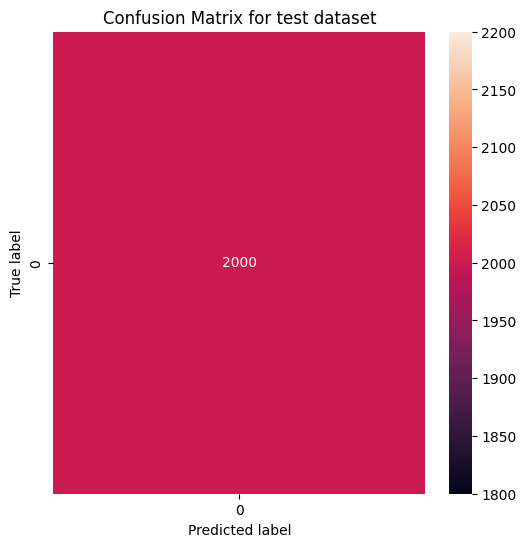

In [53]:
# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix for test dataset')
plt.show()

# Testing with SVM model

In [54]:
#import joblib

# Load the saved SVM model
# svm_model = joblib.load('svm_model_Baby_Detection.pkl')

# Load the saved scaler
# scaler = joblib.load('svm_scaler_Baby_Detection.pkl')

# Example: Preprocess test data and predict
# X_test_scaled = scaler.transform(test_x_dataset_1_reduced)
# y_pred = svm_model.predict(X_test_scaled)
# y_pred

import os
import joblib

# Define directories (2 levels up -> Models/SVM)
model_dir = os.path.join("..", "..", "Models", "Baby Detection")

# Define file paths
model_path = os.path.join(model_dir, "svm_model_Baby_Detection.pkl")
scaler_path = os.path.join(model_dir, "svm_scaler_Baby_Detection.pkl")

# Load the trained SVM model
svm_model = joblib.load(model_path)

# Load the scaler
scaler = joblib.load(scaler_path)

print(f"Model loaded from: {os.path.abspath(model_path)}")
print(f"Scaler loaded from: {os.path.abspath(scaler_path)}")

# Ensure test dataset has the same features the model was trained on
if hasattr(scaler, "feature_names_in_"):
    test_x_dataset_1_reduced = test_x_dataset_1_reduced[scaler.feature_names_in_]

# Preprocess test data and predict
X_test_scaled = scaler.transform(test_x_dataset_1_reduced)
y_pred = svm_model.predict(X_test_scaled)
y_pred



Model loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Baby Detection/svm_model_Baby_Detection.pkl
Scaler loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Baby Detection/svm_scaler_Baby_Detection.pkl


/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([1., 1., 1., ..., 1., 1., 1.], shape=(2000,))

In [55]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional: More detailed report
print("\nClassification Report:")
print(classification_report(test_y, y_pred))

# Optional: Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))


Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Confusion Matrix:
[[2000]]


/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


/Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


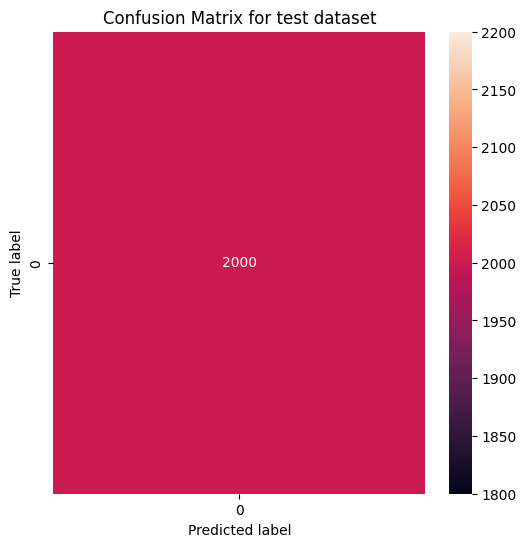

In [56]:
# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix for test dataset')
plt.show()